#### Create classification data.

In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

# create dots in a 2D space where the dots are within two concentric circles
X,y = make_circles(n_samples = n_samples,
                   noise=0.03,
                   random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[0:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [5]:
y[0:5]

array([1, 1, 1, 1, 0], dtype=int64)

Make dataframe of this data for proper visualization.

In [6]:
import pandas as pd

circles_df = pd.DataFrame({"X1":X[:,0],
                           "X2" : X[:,1],
                           "label" : y})
circles_df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


#### Visualize the data on 2D.

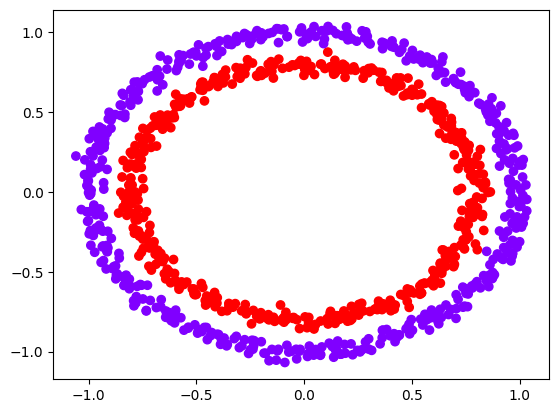

In [7]:
import matplotlib.pyplot as plt

plt.scatter(x= X[:,0],
            y = X[:,1],
            c = y,
            cmap=plt.cm.rainbow)

Turns out the data set that we generated contained dots of two types, that were separated by a hollow space between them.

#### Check input and output shapes.

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

#### Convert numpy data into tensors.

In [9]:
import torch
torch.__version__

'2.0.0+cu118'

In [10]:
X_tensor = torch.from_numpy(X).type(torch.float32)
y_tensor = torch.from_numpy(y).type(torch.float32)
len(X_tensor), len(y_tensor)

(1000, 1000)

In [11]:
X_tensor[0:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [12]:
y_tensor[0:5]

tensor([1., 1., 1., 1., 0.])

#### Train-Test split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

#### Build a classification model.

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Custom_Classifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_features=2, out_features=5) # 2 features of train data
        self.linear2 = torch.nn.Linear(in_features=5, out_features=1) # 5 nodes in the previous layer
        # using BCEWithLogitLoss, hence explicit sigmoid activation not needed
        # self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.linear1(x))

Instantiate the model.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

classifier = Custom_Classifier().to(device=device)
classifier

Custom_Classifier(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

#### Make predictions before training

In [16]:
X_test[0:5]

tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438]])

In [17]:
classifier.eval()
with torch.inference_mode():
    predictions = classifier(X_test.to(device))

predictions[0:5]

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

#### Define Loss function and Optimizer.

In [18]:
# binary cross-entropy loss with logits
# avoiding explicit definition of sigmoid layer + BCE Loss for numerical optimization
loss_func = torch.nn.BCEWithLogitsLoss()
# SGD optimizer
optimizer = torch.optim.SGD(params=classifier.parameters(), lr = 0.01)

In [19]:
#### Model Training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# notice the use of unsqueeze() to convert into the same shape as the output of the NN
X_train = X_train.to(device = device)
y_train = torch.unsqueeze(y_train, dim=1) # convert to same dimension as the network output
y_train = y_train.to(device=device)
X_test = X_test.to(device = device)
y_test = y_test.to(device=device)
y_test = torch.unsqueeze(y_test, dim = 1) # convert to same dimension as the network output

epochs = 100
epoch_ctr = []
training_loss_list = []
test_loss_list = []
training_acc_list = []
test_acc_list = []

for epoch in range(0, epochs):

    # training mode
    classifier.train()

    # raw probabilities of each class
    train_prediction_logits = classifier(X_train)
    train_prediction_probs = torch.sigmoid(train_prediction_logits)
    # rounded to 0 or 1
    train_predictions = torch.round(train_prediction_probs)
    
    # uncomment for prototyping
    assert train_prediction_logits.shape == y_train.shape
    training_loss = loss_func(train_prediction_logits, y_train) # note: prediction is in logit, y_train not in logit
    training_acc= (torch.eq(torch.squeeze(train_predictions), torch.squeeze(y_train)).sum().item()/len(y_train)) * 100.

    optimizer.zero_grad()

    training_loss.backward()

    #print("classifier.linear1.bias.grad ",classifier.linear1.bias.grad)

    optimizer.step()

    # test

    # evaluation mode
    classifier.eval()
    
    # pass X through model during eval time in inference mode to disable gradient tracking
    with torch.inference_mode():

        test_prediction_logits = classifier(X_test)
        test_prediction_probs = torch.sigmoid(test_prediction_logits)
        test_predictions = torch.round(test_prediction_probs)
        
        # uncomment for prototyping
        assert test_prediction_logits.shape == y_test.shape
        test_loss = loss_func(test_prediction_logits, y_test)
        test_acc = (torch.eq(torch.squeeze(test_predictions), torch.squeeze(y_test)).sum().item()/len(y_test)) * 100.

        # store the training and test loss for the plot
        epoch_ctr.append(epoch)
        training_loss_list.append(training_loss.to("cpu").item())
        test_loss_list.append(test_loss.to("cpu").item())
        training_acc_list.append(training_acc)
        test_acc_list.append(test_acc)

    if epoch % (epochs/10) == 0:    
        print("\nEPOCH ", epoch, " | Training loss: ",round(training_loss.detach().item(),3)," | Test loss: ", round(test_loss.item(),3),\
        " | Training acc: ",round(training_acc,3),"% | Test acc: ", round(test_acc,3), "%")


EPOCH  0  | Training loss:  0.696  | Test loss:  0.697  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  10  | Training loss:  0.695  | Test loss:  0.697  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  20  | Training loss:  0.695  | Test loss:  0.697  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  30  | Training loss:  0.695  | Test loss:  0.697  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  40  | Training loss:  0.695  | Test loss:  0.697  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  50  | Training loss:  0.695  | Test loss:  0.697  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  60  | Training loss:  0.695  | Test loss:  0.697  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  70  | Training loss:  0.694  | Test loss:  0.696  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  80  | Training loss:  0.694  | Test loss:  0.696  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  90  | Training loss:  0.694  | Test loss:  0.696  | Training acc:  50.0 % |

It appears that the model is not learning anything. Let's visualize what is going on.

#### Visualize the predictions and the performance graphs.

In [20]:
# download helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists in the directory. Skipping the download.")
else:
    print("Downloading helper_functions.py")
    raw_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    request = requests.get(raw_url)

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists in the directory. Skipping the download.


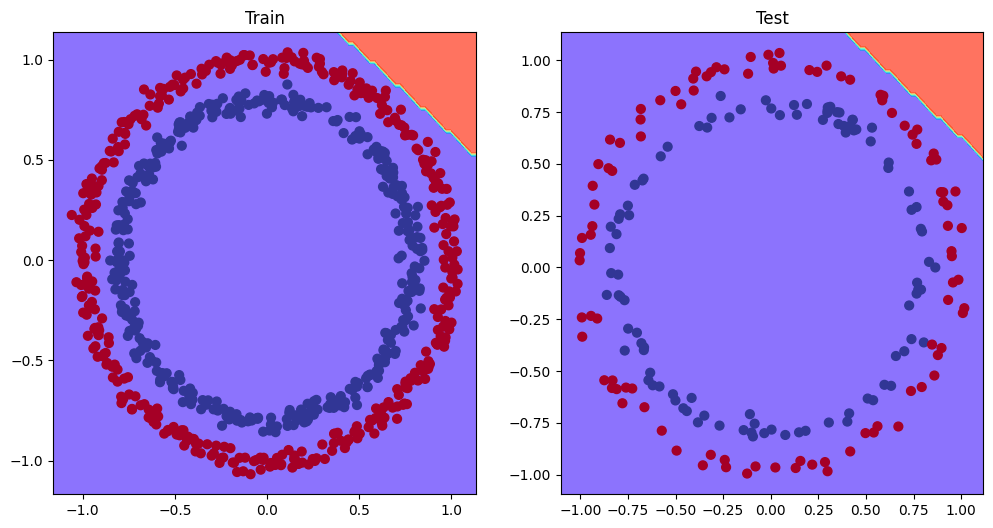

In [21]:
plt.figure(figsize=(12,6))
# 1 row in the plot, 2 columns in the plot, anything below in this slot 1
plt.subplot(1,2,1) 
plt.title("Train")
plot_decision_boundary(classifier, X_train, y_train)
# 1 row in the plot, 2 columns in the plot, anything below in this slot 2
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(classifier, X_test, y_test)

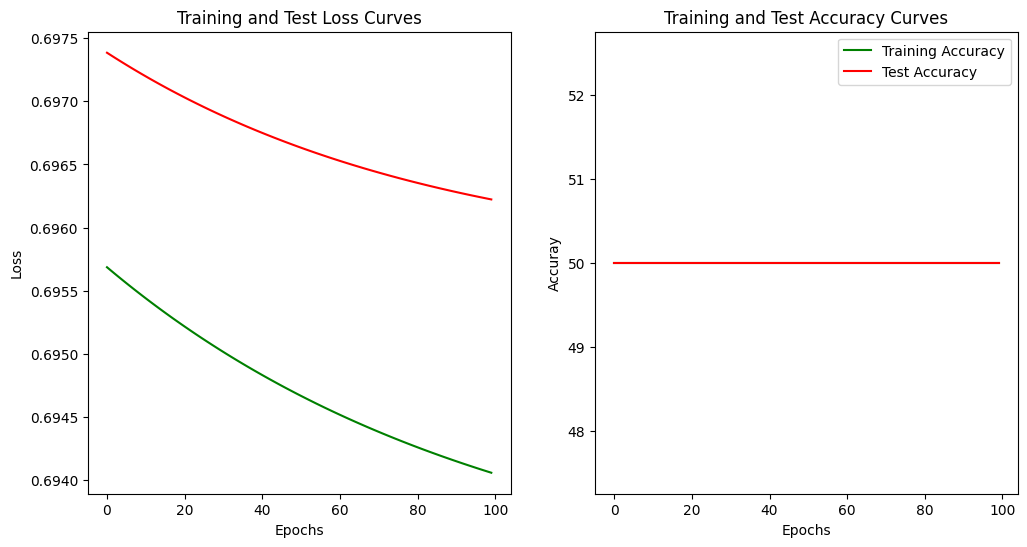

In [22]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epoch_ctr, training_loss_list, "g", label = "Training Loss")
plt.plot(epoch_ctr, test_loss_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epoch_ctr, training_acc_list, "g", label = "Training Accuracy")
plt.plot(epoch_ctr, test_acc_list, "r", label = "Test Accuracy")
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

As seen above, turns out that our classifier boundary is a straight line and thus getting ~50% accuracy consistently regardless of the training for many epochs. We want our classifier line to be non-linear.